# UNIVERSITY OF WATERLOO
# ASSIGNMENT 4 - ECE657A 
# NAVKIRAN SINGH 20802009
# SHRUTHI SRINIVASAN 20764126

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from mpl_toolkits.mplot3d import Axes3D
import requests
import numpy as np
import pandas as pd
import io
import tensorflow as tf
import matplotlib.pyplot as plt
from random import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import pandas as pd
from datetime import date
import io
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim


# READING IN THE DATASETS FOR ANALYSIS

In [ ]:
filename = "/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv"
df_confirmed = pd.read_csv(filename)
df_confirmed.head(100)

In [ ]:
filename = "/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv"
df_recovered = pd.read_csv(filename)
df_recovered.head(100)

In [ ]:
filename = "/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv"
df_deaths = pd.read_csv(filename)
df_deaths.head(100)

In [ ]:
BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = 'time_series_covid19_confirmed_global.csv'
DEATH = 'time_series_covid19_deaths_global.csv'
RECOVERED = 'time_series_covid19_recovered_global.csv'
CONFIRMED_US = 'time_series_covid19_confirmed_US.csv'
DEATH_US = 'time_series_covid19_deaths_US.csv'

def get_covid_data(subset = 'CONFIRMED'):
    """This function returns the latest available data subset of COVID-19. 
        The returned value is in pandas DataFrame type.
    Args:
        subset (:obj:`str`, optional): Any value out of 5 subsets of 'CONFIRMED',
        'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US' is a valid input. If the value
        is not chosen or typed wrongly, CONFIRMED subet will be returned.
    """    
    switcher =  {
                'CONFIRMED'     : BASE_URL + CONFIRMED,
                'DEATH'         : BASE_URL + DEATH,
                'RECOVERED'     : BASE_URL + RECOVERED,
                'CONFIRMED_US'  : BASE_URL + CONFIRMED_US,
                'DEATH_US'      : BASE_URL + DEATH_US,
                }

    CSV_URL = switcher.get(subset, BASE_URL + CONFIRMED)

    with requests.Session() as s:
        download        = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        data            = pd.read_csv(io.StringIO(decoded_content))

    return data

In [ ]:
death = get_covid_data(subset = 'DEATH')
print(death.head(10))
confirmed = get_covid_data(subset = 'CONFIRMED')
print(confirmed.head(10))
CONFIR_US = get_covid_data(subset = 'CONFIRMED_US')
DEATH_US = get_covid_data(subset = 'DEATH_US')

In [ ]:
df_1 = DEATH_US.iloc[:,12:]
df_1
df_1.isnull().sum().sum()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
df = death.iloc[:, 4:]
df.head()
df.isnull().sum().sum()

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
daily_cases_1 = daily_cases
DEATH_US = df_1.sum(axis=0)
DEATH_US.index = pd.to_datetime(DEATH_US.index)
DEATH_US.tail()

In [ ]:
df_confir = confirmed.iloc[:, 4:]
df_confir.head()
df_confir.isnull().sum().sum()
confirm_cases = df_confir.sum(axis=0)
confirm_cases.index = pd.to_datetime(confirm_cases.index)
confirm_cases.head()

In [ ]:
plt.plot(daily_cases)
plt.title("Cumulative daily death cases");

In [ ]:
dc = daily_cases.shape
dc

In [ ]:
#Subtracting the current value from previous value to know how many new cases were reported in a day
daily_cases_1 = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases_1.head()
plt.plot(daily_cases_1)
plt.title("Daily Death cases");

# Method 1 model: Using default parameter for RNN model
## RNN(Recurrent Neural Network) : Recurrent neural networks (RNN) are a class of neural networks that is powerful for modeling sequence data such as time series or natural language. Schematically, a RNN layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far


For the purpose of Assignment We used LSTM type RNN with two variations. Method 1 model uses default parameter values and those parameter values were fixed at  (n_features=1,n_hidden=512,seq_len=seq_length,n_layers=2). 
In second approach i.e. Method 2 we used another method to train the Layer's of RNN and with Data Augmentation to check which model gives us the best results.

In [ ]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
#Training RNN model w/ train and test data
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

# FINDING CORRELATIONS OF CORONAVIROUS W/ GDP AND POPULATION
# Is there any relationship between COVID-19 cases, GDP per capita and Population of that particular Country?

In [ ]:
df = pd.read_csv('../input/corona/Corona_data.csv',encoding='ISO-8859-1') # load data from csv
today = date.today()
print("Total corona virus cases in all countries on date:", today)
df[["Total cases"]] = df[["Total cases X 10^6"]]*1000
df[["Total Population in Million"]] = df[["Total Population in Million"]]*10
df.head() # Gives first 5 rows

In [ ]:
df_2 = df.iloc[:,0:13]
plt.figure(figsize=(30,30))
plt.matshow(df.corr(),fignum = 1)
plt.xticks(range(len(df_2.columns)), df_2.columns)
plt.yticks(range(len(df_2.columns)), df_2.columns)
plt.colorbar()
plt.show()

**ANALYSIS:** Correlation plot was used to find the correlations between the different features of the data. Some features were added in the data to make sense and correlate those features with the data. Features like GDP per capita of the country and Population of the country can play a significant role while dealing with the virous. 
Therefore those features were added to the data and the relationships from the corrplot are described below:
1. GDP per capita is positiviely correlated with Serious/critical cases. The correlation is about 80% which strongly suggests that GDP per capita has a correlation with Serious/Critical cases. A conclusion can be driven from here that if a country has higher GDP per capita the tedency for that country to have serious and critical cases is high.

2.Total population in million has positive correlation with total deaths which is pretty obious as well. The correlation is as high as 80% and as the population of the country increases so as the total deaths.

In [ ]:
df_1 = df.iloc[0:20]
df_1
df[["Total cases X 10^6"]] = df[["Total cases X 10^6"]]*100
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 17]
from matplotlib import figure
from matplotlib.figure import Figure
GDP = df_1['Total Population in Million'].to_numpy()
GDP
TC = df_1['Total cases'].to_numpy()
TC
index = df_1['Country'].to_numpy()
df = pd.DataFrame({'Total Population in Million': GDP,
                    'Total cases': TC}, index=index)
ax = df.plot.bar(rot=0)

Analysis: A very interesting fact that we came across from this graph is that Countries with population range of 20 million to 350 million(USA) has suffered the most from the virous. The countries with high population such as India, China, Bangladesh has relatively less cases than per million people than other countries such as USA, Spain, Italy, Turkey. We plotted top 20 countries which consitutes about 80% of the total coronavirous cases in the World. Some countries with less population in relative terms are most affected such as Spain, Italy, France, UK and Germany while others countries such as Austria and Ireland suffered less.
Another interesting fact that we found out about the virous is that 15 out of the total 20 countries are in Europe or North America which means that due to easy border restrictions in Europe the virous spreaded quickly through the europe as opposed to the south east asia where there are far less cases of the virous. Therefore Europe right now acts as the centre for the virous.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 17]
from matplotlib import figure
from matplotlib.figure import Figure
GDP = df_1['GDP per capita'].to_numpy()
GDP
TC = df_1['Total cases'].to_numpy()
TC
index = df_1['Country'].to_numpy()
df = pd.DataFrame({'GDP per capita': GDP,
                    'Total cases': TC}, index=index)
ax = df.plot.bar(rot=0)

Analysis: This bar graph was included to support the bar graph given above. As from this it can be concluded that virous spreaded heavily in the Rich countries. Countries with GDP per capita more than 25000 has high cases of the coronavirous while the poor countries such as IRAN, INDIA, TURKEY AND CHINA has relatively less cases than the other countries. It can be stated as to the slow testing rate of the poor countries as not many resources are available but till date the RICh countries have high concentration of the virous.
Many coutries with per capita GDP more than 25000$ such as USA, ITALY, GERMANY, UK, BELGIUM and CANADA has more cases in comparison to the poor countries.
The study and interpretation can be inculded in the future work about coronovirous and other factors such as epidenmic history and other diesaese data can be inluded in the analysis as well. Overall the graph shows that the poor countries have less cases than the coutries with GDP per capita more than 25K USD.


# PREDICTING DEATHS USING RECURRENT NEURAL NETWORK BY SPLITTING DATA AS 80% FOR TRAINING FOR 20% FOR TESTING

In [ ]:
#Splitting training and testing data into 80/20 ratio. 80% for training and 20% for testing
test_data_size = 18
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data.shape
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape
X_train[:2]
y_train.shape
y_train[:2]
train_data[:10]

In [ ]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

**Analysis: As we can see that with each and every iteration the training and test loss is decreasing. As the algorithm learns data and the best training loss is acheived after 50 epoch's.**

In [ ]:
plt.plot(train_hist, label="Training loss for death data")
plt.plot(test_hist, label="Test loss for death data")
plt.ylim((0, 5))
plt.legend();

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily death Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily death Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily death Cases'
)

plt.legend();

Analysis: After doing the 80 and 20% spit of training and testing data we saw that our model perfromance worsend as both the values of real and predicted value are far away from each other. This might be due to the reason that when we do 80/20 split and there is very less training data and even less to test as well. There is not much training data therefore model is not able to perform that great.

# Making use of all the data available to predict the deaths using RNN

In [ ]:
#Now using all data to predcit deaths using RNN
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Death Cases')
plt.legend();

In [ ]:
plt.plot(daily_cases, label='Historical Daily Death Cases')
plt.plot(predicted_cases, label='Predicted Daily Death Cases')
plt.legend();

**Analysis: After using whole dataset we found out that our model performs the best and but unfortunately as RNN suggest that death toll to keep rising and with prediction it shows that there will be in total 120,000 more deaths by the early May.There is no sign for the curve to slow down therefore it shows that this trend is going to continue for next few days. At the time of writing this report there were 5400 cases in a single day. Therefore the trend seems to be justified in the next few days. The whole graph is exponential as the values on Y axis are very small and to the degree of 10^6. I used this algorithm to predict the total deaths in the next 12 days.**

# USING RNN WITH ALL DATA TO PREDICT TOTAL CONFIRMED CASES FROM TODAY TO NEXT 30 DAYS

In [ ]:
#Now using all data to predcit cnfirmed cases using RNN
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(confirm_cases, axis=1))
all_data = scaler.transform(np.expand_dims(confirm_cases, axis=1))
all_data.shape

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
seq_length = 5
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 30
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
daily_cases.index[-1]

In [ ]:
predicted_index = pd.date_range(
  start=confirm_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(predicted_cases, label='Predicted Daily Confirmed Cases')
plt.legend();

In [ ]:
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(confirm_cases, label='Historical Daily Confirmed Cases')
plt.plot(predicted_cases, label='Predicted Daily Confirmed Cases')
plt.legend();

**Analysis: After using the total dataset for confirmed cases using RNN the algorithm predicts that by May 15th, there will be total of 2 million more confirmed cases in the world. The algorithm suggests that the curve of total confirmed cases will almost become flat after 2 millions more cases and will increase very slowly. The trend seems reasonable as in few countries this virous is just at its early stages and we can expect more cases to unearth in the coming few days.**

In [ ]:
BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = 'time_series_covid19_confirmed_global.csv'
DEATH = 'time_series_covid19_deaths_global.csv'
RECOVERED = 'time_series_covid19_recovered_global.csv'
CONFIRMED_US = 'time_series_covid19_confirmed_US.csv'
DEATH_US = 'time_series_covid19_deaths_US.csv'

def get_covid_data(subset = 'CONFIRMED'):
    """This function returns the latest available data subset of COVID-19. 
        The returned value is in pandas DataFrame type.
    Args:
        subset (:obj:`str`, optional): Any value out of 5 subsets of 'CONFIRMED',
        'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US' is a valid input. If the value
        is not chosen or typed wrongly, CONFIRMED subet will be returned.
    """    
    switcher =  {
                'CONFIRMED'     : BASE_URL + CONFIRMED,
                'DEATH'         : BASE_URL + DEATH,
                'RECOVERED'     : BASE_URL + RECOVERED,
                'CONFIRMED_US'  : BASE_URL + CONFIRMED_US,
                'DEATH_US'      : BASE_URL + DEATH_US,
                }

    CSV_URL = switcher.get(subset, BASE_URL + CONFIRMED)

    with requests.Session() as s:
        download        = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        data            = pd.read_csv(io.StringIO(decoded_content))

    return data

# COMPARISON OF RNN PREDICTIONS W/ REAL VALUES OF DAILY CORONAVIROUS CASES OR THE LAST 18 DAYS

In [ ]:
##COMPARISON
test_data_size = 18
train_data = daily_cases_1[:-test_data_size]
test_data = daily_cases_1[-test_data_size:]
train_data.shape

In [ ]:
test_data.shape

In [ ]:
#Comparison of RNN with real daily cases
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

all_data = scaler.transform(np.expand_dims(train_data, axis=1))

all_data.shape

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 18

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
train_data.index[-1]

In [ ]:
predicted_index = pd.date_range(
  start=train_data.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
plt.plot(train_data, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.plot(test_data,label='Real daily cases')
plt.legend();

Analysis: After applying RNN with default parameters on the given data we found out that there is a error between the prediction of the RNN model and real daily corona virous cases. This can be contributed to the fact that there is still less data avialble for the analysis and lot of physical factors are involved in the spread of the virous therefore It is very hard for a algorithm to predict all the physical factors and daily corona cases. However the model suggests that the cases curve will flatten out few days after the mid of the month which is the case in the real scenario as well. In real scenario the count for daily cases jumped by 10,000 but the algothirm predicts them to jump to 60000 and then keep constant.

# USING second technique for RNN to predict using Data Augmentation

In [ ]:
def covid_model(input_len):
  covid_19_RNN=tf.keras.models.Sequential()
  #input layer
  covid_19_RNN.add(tf.keras.layers.LSTM(units = 250, return_sequences=True,input_shape=(input_len,1)))
  covid_19_RNN.add(tf.keras.layers.Dropout(0.01))
  #1st hidden layer
  covid_19_RNN.add(tf.keras.layers.LSTM(units = 150, return_sequences=True))
  covid_19_RNN.add(tf.keras.layers.Dropout(0.01))
  # #2nd hidden layer
  covid_19_RNN.add(tf.keras.layers.LSTM(units = 200, return_sequences=True))
  covid_19_RNN.add(tf.keras.layers.Dropout(0.02))
  #3rd hidden layer
  covid_19_RNN.add(tf.keras.layers.LSTM(units = 150, return_sequences=True))
  covid_19_RNN.add(tf.keras.layers.Dropout(0.02))
  #4th hidden layer
  covid_19_RNN.add(tf.keras.layers.LSTM(units = 125, return_sequences=True))
  covid_19_RNN.add(tf.keras.layers.Dropout(0.04))
  #output layer
  covid_19_RNN.add(tf.keras.layers.Dense(units = 1))
  #compile the model
  covid_19_RNN.compile(optimizer='adam',loss='mae')
  return covid_19_RNN
# Initializing Parameters
TEST_PORTION = 0
TEST_SIZE = 14 
OBSERVATION_WINDOW_SIZE = 14
AUGMENTATION_LEVEL = 50
AUGMENTATION_SCORE = 0.13
INPUT_FILE = 'CONFIRMED'
"""
INPUT_FILE : 'CONFIRMED', 'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US'
"""

In [ ]:
# Reading the Input File

df = get_covid_data(subset = INPUT_FILE)
print(df)

if 'US' in INPUT_FILE:
  data_start = 10
else:
  data_start = 3

confirmed_data=pd.DataFrame(df.sum(axis=0))[data_start:]
dates=list(confirmed_data.index)
test_size = np.asarray(max( np.round( len(dates) * TEST_PORTION ) , TEST_SIZE )).astype(int)
time_steps = max( OBSERVATION_WINDOW_SIZE , 1)
aug_steps = max( AUGMENTATION_LEVEL , 1)
scaler_threshold = min( AUGMENTATION_SCORE, 0.2 )

day=[]
for i in range(0,len(dates)):
  day.append(i+1)
day=np.array(day)

In [ ]:
# Augmentation and Preprocessing of the Train Data
scaler = MinMaxScaler( feature_range=(random()*0.2,1-random()*0.2) )
train_data = confirmed_data[:-test_size]
x_data=[]
y_data=[]
for j in range(0,aug_steps):
    for i in range(time_steps,len(train_data)):
        scaler=MinMaxScaler( feature_range=(random()*scaler_threshold, 1 - random()*scaler_threshold) )
        augmentation = scaler.fit_transform(train_data[i-time_steps:i+1])
        x_data.append(augmentation[:time_steps])
        y_data.append(augmentation[time_steps])
x_data = np.array(x_data)
x_data = np.reshape(x_data,(x_data.shape[0],x_data.shape[1],1))
y_data = np.array(y_data)

In [ ]:
# Fitting the model to the augmented data
covid_19_RNN = covid_model(x_data.shape[1])
covid_19_RNN.fit(x_data ,y_data , batch_size=2048 , epochs=200 , validation_split=0.4 , verbose=2)

In [ ]:
# The test data sequence generation and preprocessing
test_data = confirmed_data.values
test_data = test_data[-(test_size + time_steps):]
test_data = np.array(test_data).reshape(-1,1)

In [ ]:
# Prediction using the trained covid_19_RNN model
scaler=MinMaxScaler( feature_range = (scaler_threshold, 1 - scaler_threshold) )
prediction_result = []
for i in range(time_steps ,len(test_data)):
  x_test = []
  x_test.append( scaler.fit_transform(test_data[ i - time_steps : i ]) )
  x_test = np.reshape(x_test[0],(1 , x_test[0].shape[0], 1))
  predicted_covid_19_spread = covid_19_RNN.predict(x_test)[0][-1]
  predict_val = scaler.inverse_transform(predicted_covid_19_spread.reshape(1,1))
  predict_val = predict_val.astype(int)
  prediction_result.append(predict_val[0][0])

y_test = test_data[time_steps : len(test_data)]
y_test = y_test.reshape(len(y_test)).astype(int)

In [ ]:
# Test Data Results
result_error = prediction_result - y_test
result_error_percentage = 100*np.divide(result_error, y_test)
test_dates  = np.asarray(dates[-len(y_test):]).reshape(len(y_test))
real_value  = y_test.reshape(len(y_test)).astype(int)
predition   = np.asarray(prediction_result)
error_p     = result_error_percentage.reshape(len(y_test))
error_p     = np.around(error_p, decimals=2)
Results = {'Date': test_dates, 'Real Value [No.]': real_value, 'Predicted Value [No.]': predition, 'Error Percentage [%]':error_p}
df_results = pd.DataFrame(data=Results)
print(df_results)
MAEP  = mean_absolute_error(predition, y_test)
MAEP  = np.around(MAEP, decimals=0)
print('MAE of Prediction                 :' + str(MAEP))
MAPEP = mean_absolute_error(error_p,np.zeros(len(error_p)))
MAPEP = np.around(MAPEP, decimals=2)
print('Mean Absolute of Prediction Error Percentages  [%]:' + str(MAPEP))

In [ ]:
plt.figure(2, figsize=(12,9))
plt.plot(range(0,len(confirmed_data)),confirmed_data[0],label="Actual Number of corona-cases", c='g')
plt.plot(range(len(confirmed_data) - test_size ,len(confirmed_data)),prediction_result,label="Prediction of Number of corona-cases",c='r')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.legend()
plt.grid(which='both', axis='both')
plt.title('Daily prediction of COVID-19 Cases - ' + INPUT_FILE.upper() + ' GLOBAL')
plt.show()

**Analysis: Using Method 2 for RNN with data augmentation the prediction is coming out to be very precise. The prediction follows the actual number of the cases very closely and it is clear that RNN with 4 input layers is performing very well to predict the number of cases of COVID-19. As given in the graph the data follows an exponential curve and trend seems to increase for now.**

In [ ]:
# Prediction using the trained covid_19_RNN model
scaler=MinMaxScaler( feature_range = (scaler_threshold, 1 - scaler_threshold) )
prediction_result = []

for i in range(time_steps ,len(test_data)):
  x_test = []
  x_test.append( scaler.fit_transform(test_data[ i - time_steps : i ]) )
  x_test = np.reshape(x_test[0],(1 , x_test[0].shape[0], 1))
  predicted_covid_19_spread = covid_19_RNN.predict(x_test)[0][-1]
  predict_val = scaler.inverse_transform(predicted_covid_19_spread.reshape(1,1))
  predict_val = predict_val.astype(int)
  test_data[i]= predict_val
  prediction_result.append(predict_val[0][0])

test_data = confirmed_data.values
test_data = test_data[-(test_size + time_steps):]
test_data = np.array(test_data).reshape(-1,1)

y_test = test_data[time_steps : len(test_data)]
y_test = y_test.reshape(len(y_test)).astype(int)

In [ ]:
# Test Data Results
result_error = prediction_result - y_test
result_error_percentage = 100*np.divide(result_error, y_test)
test_dates  = np.asarray(dates[-len(y_test):]).reshape(len(y_test))
real_value  = y_test.reshape(len(y_test)).astype(int)
predition   = np.asarray(prediction_result)
error_p     = result_error_percentage.reshape(len(y_test))
error_p     = np.around(error_p, decimals=2)
Results = {'Date': test_dates, 'Real Value [No.]': real_value, 'Predicted Value [No.]': predition, 'Error Percentage [%]':error_p}
df_results = pd.DataFrame(data=Results)
print(df_results)
MAEP  = mean_absolute_error(predition, y_test)
MAEP  = np.around(MAEP, decimals=0)
print('\nMean Absolute Error of Prediction                 :' + str(MAEP))
MAPEP = mean_absolute_error(error_p,np.zeros(len(error_p)))
MAPEP = np.around(MAPEP, decimals=2)
print('Mean Absolute of Prediction Error Percentages  [%]:' + str(MAPEP))

**ANALYSIS: After using Method 2 to predict confirmed cases of coronavirous using Recuurent neural network with LSTM method and by adding more layers and data augmentation to the model the accuracy was pretty acurate and the error percentage got reduced to 7.7%. The maximum individua error for a particular day was 17.76% for 20th April. 
The graph generated that the prediction using RNN was quite accurate and the curve was pretty similar to the real data.
As RNN and LSTM use sequential processing over the time therefore the predictions were quite accurate with second model.
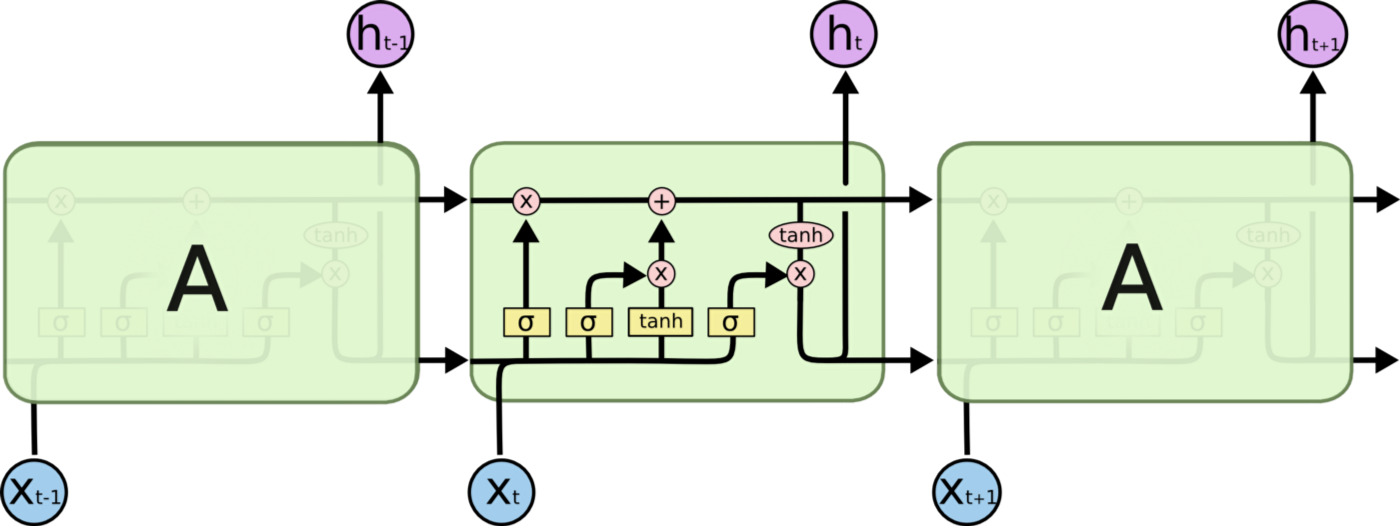**

**The LSTM module, which today can be seen as multiple switch gates, and a bit like ResNet it can bypass units and thus remember for longer time steps. LSTM thus have a way to remove some of the vanishing gradients problems.LSTM and GRU and derivatives are able to learn a lot of longer term information which help LSTM in time series analysis**.** Therefore we conclude that model 2 should be used for time series analysis as It takes data and use data augmentation in addition to different hidden layers of the network to have good time series results.**